# PROTOTYPE

Train on Food101 image with size 224x224 use pre-trained ResNet50 model with data augmentation

## Data Exploration 

### Build Data Frame from the source files

In [1]:
import zipfile
import os

files = zipfile.ZipFile('food101.zip', 'r')
files.extractall(os.getcwd())
files.close()  

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
# imports
from fastai import *
from fastai.vision import *
from fastai.callbacks.hooks import *

import seaborn as sns

In [4]:
path = Path('food101')
path_meta = path /'meta'
path_images = path/'images'

In [5]:
path_meta

PosixPath('food101/meta')

In [6]:
def build_data_frame(path_name, file_name, img_format = 'jpg'):
    """
    build_data_frame input the path and file name, the function will return the dataframe with two columns:
    ['label'] : image label
    ['image_file'] : image file name with directory information
    input paramters:
    path_name : path 
    file_name : file name, string
    img_format : default format is jpg
    
    return dataframe
    """
    path_file = path_name/file_name
    file_df = pd.read_csv(path_file,delimiter='/', header=None, names=['label', 'image_file'])
    file_df['image_file'] = file_df['label'].astype(str) + '/' + file_df['image_file'].astype(str) + '.'+img_format
    
    return file_df

In [7]:
train_df = build_data_frame(path_meta, 'train.txt')
test_df = build_data_frame(path_meta, 'test.txt')

In [8]:
train_df.head()

label             image_file
0  apple_pie  apple_pie/1005649.jpg
1  apple_pie  apple_pie/1014775.jpg
2  apple_pie  apple_pie/1026328.jpg
3  apple_pie  apple_pie/1028787.jpg
4  apple_pie  apple_pie/1043283.jpg

In [9]:
test_df.head()

label             image_file
0  apple_pie  apple_pie/1011328.jpg
1  apple_pie   apple_pie/101251.jpg
2  apple_pie  apple_pie/1034399.jpg
3  apple_pie   apple_pie/103801.jpg
4  apple_pie  apple_pie/1038694.jpg

### Data Block API 


In [10]:
bs = 64

In [11]:
# Explore the dataset

train_data = ImageList.from_df(df=train_df,path=path_images, cols=1)\
              .split_by_rand_pct(0.2)\
              .label_from_df(cols=0)\
              .transform(get_transforms(), size=224)\
              .databunch(bs=bs)
 
              

In [12]:
train_data

ImageDataBunch;

Train: LabelList (60600 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
apple_pie,apple_pie,apple_pie,apple_pie,apple_pie
Path: food101/images;

Valid: LabelList (15150 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
chicken_curry,creme_brulee,strawberry_shortcake,hot_dog,bibimbap
Path: food101/images;

Test: None

In [13]:
print('Total data classes:',str(len(train_data.classes)))
print('Food Classes: \n', train_data.classes)

Total data classes: 101
Food Classes: 
 ['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheese_plate', 'cheesecake', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros', 'hummus', 'ice_cream', 'lasagna', 'lobster_bisque', 'lobster_roll_sandwich', 'mac

### Explore the Image

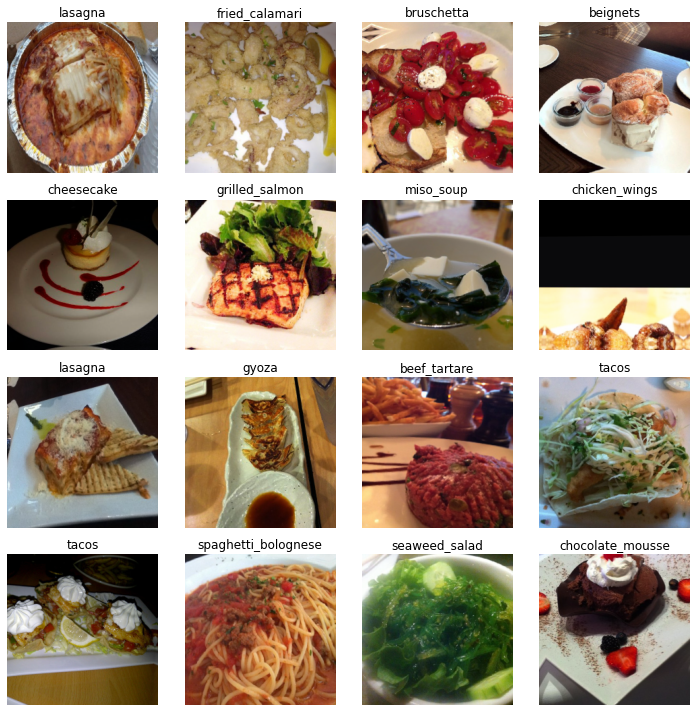

In [14]:
train_data.show_batch(rows=4, figsize=(10, 10))

In [15]:
train_data.classes[0]

'apple_pie'

### Explore each Class images


In [16]:
np.random.seed(2)
def build_class_data(class_name):
    
    class_path = path_images/class_name
    fnames = get_image_files(class_path)
    pat = r'/([^/]+)/\d+.jpg$'
    class_data = ImageDataBunch.from_name_re(class_path, fnames, pat, ds_tfms=get_transforms(), size=224, bs=bs
                                  ).normalize(imagenet_stats)

    return class_data

In [17]:
def show_class_images(class_name, row_number = 4, fig_size = (10,10)):
    
    class_data = build_class_data(class_name)
    print('Class Name: ', class_name)
    class_data.show_batch(rows=row_number, figsize=fig_size)
    
    return 

Class Name:  apple_pie


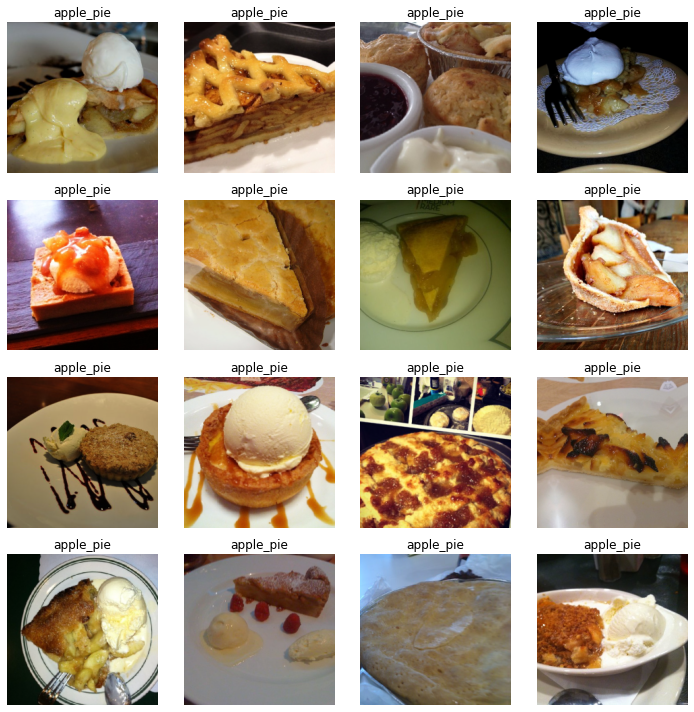

In [18]:
show_class_images(train_data.classes[0])

Class Name:  bruschetta


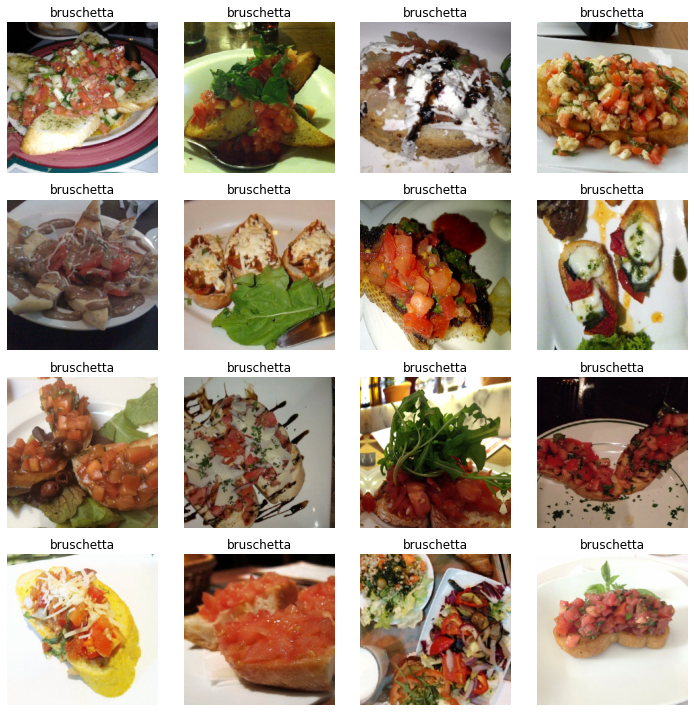

In [19]:
show_class_images(train_data.classes[10])

### Data Augmentation


In [20]:
tfms = get_transforms(max_rotate=15, max_zoom=1.3, max_lighting=0.4, max_warp=0.4,
                      p_affine=1., p_lighting=1.)

In [21]:
def build_class_data_with_tfms(class_name, padding_mode):
    
    class_path = path_images/class_name
    fnames = get_image_files(class_path)
    pat = r'/([^/]+)/\d+.jpg$'
    class_data = ImageDataBunch.from_name_re(class_path, fnames, pat, \
                                             ds_tfms=tfms, size=224, \
                                             padding_mode=padding_mode,\
                                             bs=bs)\
                                            .normalize(imagenet_stats)

    return class_data

In [22]:
def show_class_images_with_tfms(class_name,padding_mode, row_number = 4, fig_size = (10,10)):
    
    class_data = build_class_data_with_tfms(class_name,padding_mode)
    print('Class Name: ', class_name)
    class_data.show_batch(rows=row_number, figsize=fig_size)
    
    return

Class Name:  apple_pie


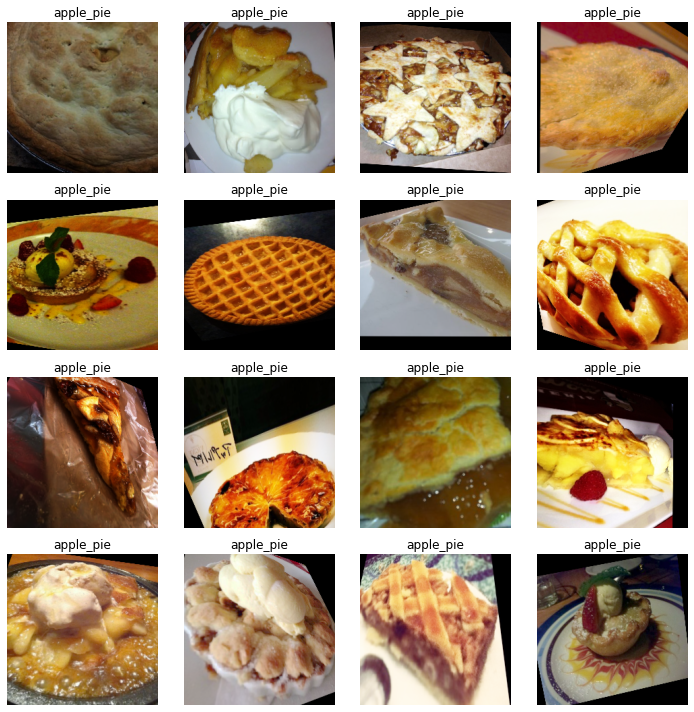

In [23]:
show_class_images_with_tfms(train_data.classes[0],padding_mode = 'zeros')

### Show single image with data augmentation

In [24]:
fnames = get_image_files(path_images/train_data.classes[0])

In [25]:
fnames[1]

PosixPath('food101/images/apple_pie/3517723.jpg')

In [26]:
def show_img_augmentation(image_file_name, rows=3,cols=3,width=9,height=9):
    
    img = open_image(image_file_name)
    print('Image Before/After Augmentation:')
    img.show()
    

    [img.apply_tfms(get_transforms()[0]).show(ax=ax) \
      for i,ax in enumerate(plt.subplots(rows,cols,figsize=(width,height))[1].flatten())];
    
    return

    

Image Before/After Augmentation:


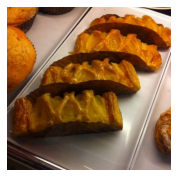

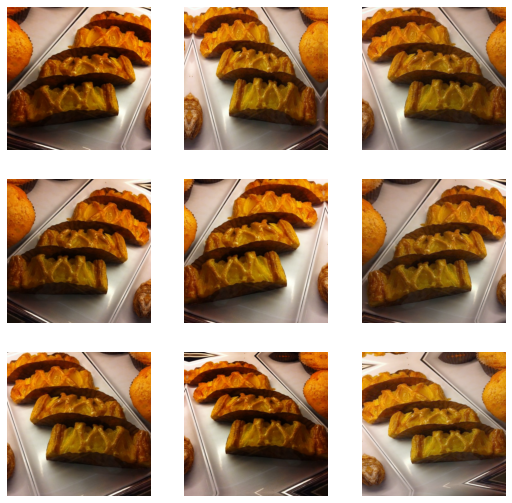

In [27]:
show_img_augmentation(get_image_files(path_images/train_data.classes[0])[10])

### Set the Random Data Augmentation Parameters

In [28]:
Crop_pads = RandTransform(tfm=TfmCrop(crop_pad),\
                       kwargs={'row_pct': (0, 1), 'col_pct': (0, 1), 'padding_mode': 'reflection'}, \
                       p=1.0, \
                       resolved={}, \
                       do_run=True, \
                       is_random=True)

Affine_flip = RandTransform(tfm=TfmAffine(flip_affine),\
                            kwargs={}, \
                            p=0.5, \
                            resolved={}, \
                            do_run=True, \
                            is_random=True)

Coord_warp = RandTransform(tfm=TfmCoord(symmetric_warp), \
                           kwargs={'magnitude': (-0.2, 0.2)}, \
                           p=0.75, \
                           resolved={}, \
                           do_run=True, \
                           is_random=True)

Affine_rotate = RandTransform(tfm=TfmAffine(rotate),\
                              kwargs={'degrees': (-20.0, 20.0)}, \
                              p=0.75, \
                              resolved={}, \
                              do_run=True, \
                              is_random=True)

Affine_zoom = RandTransform(tfm=TfmAffine(zoom), \
                            kwargs={'scale': (1.0, 1.3), 'row_pct': (0, 1), 'col_pct': (0, 1)}, \
                            p=0.75, \
                            resolved={}, \
                            do_run=True, \
                            is_random=True)

Lighting_brightness = RandTransform(tfm=TfmLighting(brightness), \
                         kwargs={'change': (0.4, 0.6)}, \
                         p=0.75, \
                         resolved={}, \
                         do_run=True, \
                         is_random=True)

Lighting_contrast = RandTransform(tfm=TfmLighting(contrast),\
                                  kwargs={'scale': (0.8, 1.25)}, \
                                  p=0.75, \
                                  resolved={}, \
                                  do_run=True,\
                                  is_random=True)

Crops = RandTransform(tfm=TfmCrop(crop_pad), \
                      kwargs={}, \
                      p=1.0, \
                      resolved={},\
                      do_run=True, \
                      is_random=True)

# Training Set Random Augmentation
train_tfms = [Crop_pads,Affine_flip,Coord_warp,Affine_rotate,Affine_zoom,Lighting_brightness,Lighting_contrast]

# Validation Set Random Augmentation
valid_tfms = [Crops]

random_tfms = (train_tfms,valid_tfms

In [29]:
train_model_data = (ImageList.from_df(df=train_df,path=path_images, cols=1)\
                            .split_by_rand_pct(0.2)\
                            .label_from_df(cols=0)\
                            .transform(random_tfms, size=224)\
                            .databunch(bs=bs)\
                            .normalize(imagenet_stats))

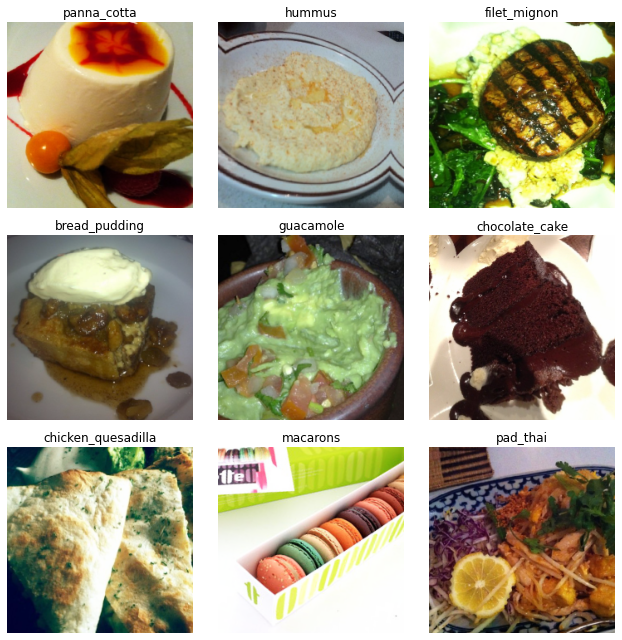

In [30]:
train_model_data.show_batch(rows=3, figsize=(9, 9))

### Metrics

**Top-1 Accuracy** and **Top-5 Accuracy** 

In [31]:
top_5_accuracy = partial(top_k_accuracy, k=5)

learn = cnn_learner(train_model_data, models.resnet50, metrics=[accuracy, top_5_accuracy], callback_fns=ShowGraph)

### Model Structure

In [32]:
learn.model[1]

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Flatten()
  (2): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=4096, out_features=512, bias=True)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=101, bias=True)
)

In [33]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256

### Model Train

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


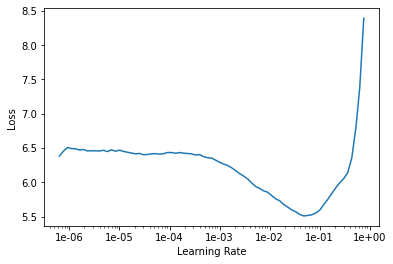

In [34]:
learn.lr_find()
learn.recorder.plot()

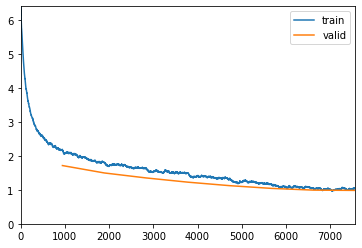

In [35]:
lr = 1e-2
learn.fit_one_cycle(8, slice(lr))
learn.save('food-101-ResNet50-prototype')

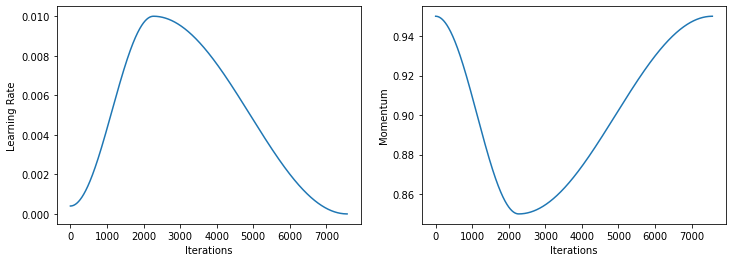

In [36]:
# the learning rate and momentum scheduling 
learn.recorder.plot_lr(show_moms=True)

# Experiment 1#

Train on Food101 image with size 224x224 use unfreeze ResNet50 model with data augmentation

### Unfreeze ResNet50 Model 

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 8.32E-06
Min loss divided by 10: 6.31E-08


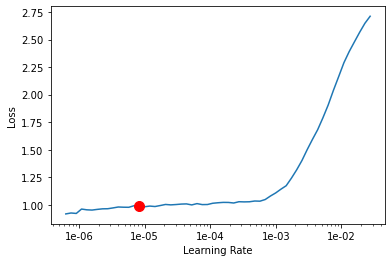

In [37]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

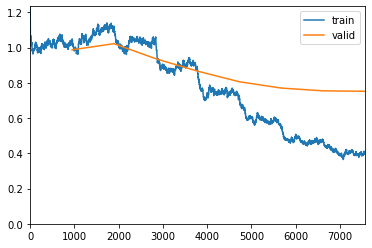

In [38]:
learn.fit_one_cycle(8, max_lr=slice(1e-5, 1e-3))
learn.save('food-101-ResNet50-244-yesyes')

In [39]:
learn.load('food-101-ResNet50-244-yesyes')

Learner(data=ImageDataBunch;

Train: LabelList (60600 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
apple_pie,apple_pie,apple_pie,apple_pie,apple_pie
Path: food101/images;

Valid: LabelList (15150 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
hummus,scallops,peking_duck,chicken_quesadilla,baby_back_ribs
Path: food101/images;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, ep

In [44]:
torch.cuda.empty_cache()